## Modelagem de Features

In [14]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import rcParams
from pandas_profiling import ProfileReport
from shutil import copy2
from sklearn.ensemble import IsolationForest
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA


# Matplotlib options
rcParams['figure.figsize'] = (10, 8)
rcParams['axes.grid'] = False
plt.style.use('seaborn-deep')

# Pandas setup
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_colwidth', -1) 

In [12]:
# Read file
path = "./datasets/"
name = "p2"
filename = name + ".csv"
df = pd.read_csv(path + filename, encoding='utf8', parse_dates=True, index_col="DATE")
cols = df.columns

In [3]:
# profile = ProfileReport(df, explorative=True)
# profile.to_notebook_iframe()

In [4]:
clf = IsolationForest(
    n_estimators=100, 
    max_samples='auto', 
    contamination=0.01, 
    max_features=1.0, 
    bootstrap=False, 
    n_jobs=-1, 
    random_state=42, 
    verbose=0
)

cols = df.columns
metrics_df = df.copy()
metrics_df = metrics_df.reset_index()

clf.fit(metrics_df[cols])
pred = clf.predict(metrics_df[cols])
metrics_df['anomaly'] = pred
outliers = metrics_df.loc[metrics_df['anomaly'] == -1]
outlier_index = list(outliers.index)
#print(outlier_index)

#Find the number of anomalies and normal points here points classified -1 are anomalous
print(metrics_df['anomaly'].value_counts())

 1    83
-1    1 
Name: anomaly, dtype: int64


In [5]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import chart_studio.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
import warnings


init_notebook_mode(connected=True)


def classify_anomalies(df,metric_name):
    df['metric_name'] = metric_name
    df = df.sort_values(by='load_date', ascending=False)
    #Shift actuals by one timestamp to find the percentage chage between current and previous data point
    df['shift'] = df['actuals'].shift(-1)
    df['percentage_change'] = ((df['actuals'] - df['shift']) / df['actuals']) * 100
    #Categorise anomalies as 0-no anomaly, 1- low anomaly , 2 - high anomaly
    df['anomaly'].loc[df['anomaly'] == 1] = 0
    df['anomaly'].loc[df['anomaly'] == -1] = 2
    df['anomaly_class'] = df['anomaly']
    max_anomaly_score = df['score'].loc[df['anomaly_class'] == 2].max()
    medium_percentile = df['score'].quantile(0.24)
    df['anomaly_class'].loc[(df['score'] > max_anomaly_score) & (df['score'] <= medium_percentile)] = 1
    
    return df


def plot_anomaly(df,metric_name):
    df.load_date = pd.to_datetime(df['load_date'].astype(str), format="%Y-%m-%d")
    dates = df.load_date
    #identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) > 0)
    actuals = df["actuals"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    #A dictionary for conditional format table based on anomaly
    color_map = {0: "'rgba(228, 222, 249, 0.65)'", 1: "yellow", 2: "red"}
    
    #Table which includes Date,Actuals,Change occured from previous point
    table = go.Table(
        domain=dict(x=[0, 1],
                    y=[0, 0.3]),
        columnwidth=[1, 2],
        # columnorder=[0, 1, 2,],
        header=dict(
                height=20,
                values=[
                        ['<b>Date</b>'], 
                        ['<b>Actual Values </b>'], 
                        ['<b>% Change </b>'],
                ],
                font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                fill=dict(color='#d562be')
                ),
        cells=dict(
                values=[df.round(3)[k].tolist() for k in ['load_date', 'actuals', 'percentage_change']],
                line=dict(color='#506784'),
                align=['center'] * 5,
                font=dict(color=['rgb(40, 40, 40)'] * 5, size=12),
                suffix=[None] + [''] + [''] + ['%'] + [''],
                height=27)
                # fill=dict(color=[test_df['anomaly_class'].map(color_map)],#map based on anomaly level from dictionary)
                )
    #Plot the actuals points
    Actuals = go.Scatter(
        name='Válidos',
        x=dates,
        y=df['actuals'],
        xaxis='x1', yaxis='y1'
        )
    #Highlight the anomaly points
    anomalies_map = go.Scatter(
        name="Anomalias",
        showlegend=True,
        x=dates,
        y=anomaly_points,
        mode='markers',
        xaxis='x1',
        yaxis='y1',
        marker=dict(
                color="red",
                size=11,
                line=dict(color="red", width=2)
        )
    )
    axis = dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10))
    layout = dict(
        width=1000,
        height=865,
        autosize=False,
        title=metric_name,
        margin=dict(t=75),
        showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))
    fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)
    iplot(fig)
    pyplot.show()

In [6]:
warnings.filterwarnings('ignore')
predictions = pd.DataFrame()

for i in range(1,len(metrics_df.columns)-1):
    clf.fit(metrics_df.iloc[:,i:i+1])
    pred = clf.predict(metrics_df.iloc[:,i:i+1])
    test_df=pd.DataFrame()
    test_df['load_date']=metrics_df['DATE']
    #Find decision function to find the score and classify anomalies
    test_df['score']=clf.decision_function(metrics_df.iloc[:,i:i+1])
    test_df['actuals']=metrics_df.iloc[:,i:i+1]
    test_df['anomaly']=pred
    predictions[str(metrics_df.columns[i])]=pred
    #Get the indexes of outliers in order to compare the metrics     with use case anomalies if required
    outliers=test_df.loc[test_df['anomaly']==-1]
    outlier_index=list(outliers.index)
    test_df=classify_anomalies(test_df,metrics_df.columns[i])
    plot_anomaly(test_df,metrics_df.columns[i])

In [7]:
# substituir outliers por nulo
predictions.index = df.index
sub = df.copy()

for col in df.columns:
  sub[col] =  predictions[col].map(lambda x: x == -1)

df_clipped = df.mask(sub, np.nan)

imputer = KNNImputer(
    missing_values=np.nan, 
    n_neighbors=11, 
    weights='distance', 
    metric='nan_euclidean', 
    copy=True
)

df_imputed = pd.DataFrame(imputer.fit_transform(df_clipped), index=df_clipped.index, columns=df_clipped.columns)

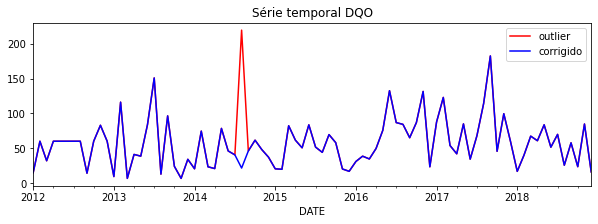

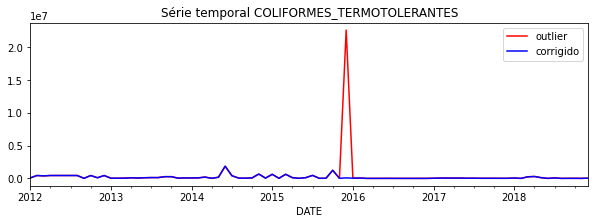

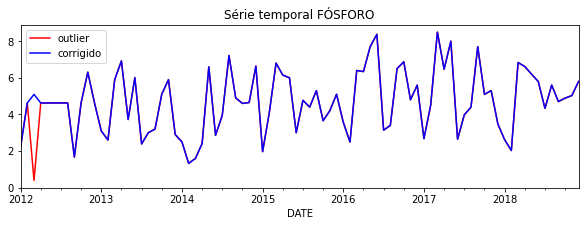

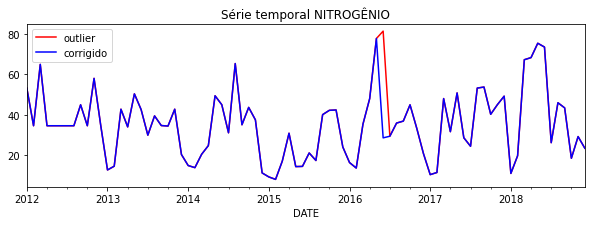

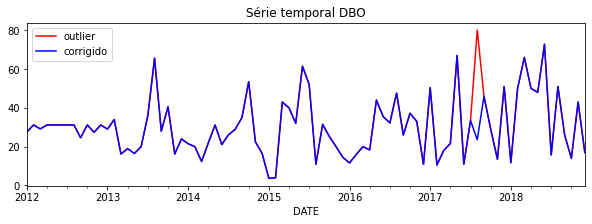

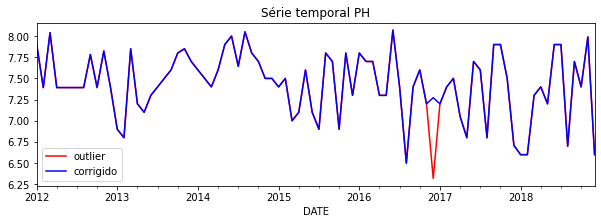

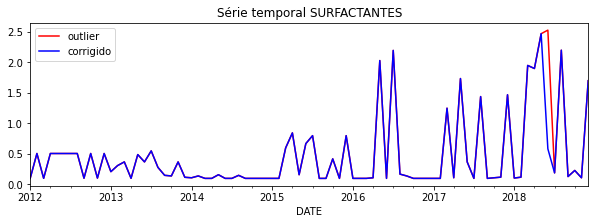

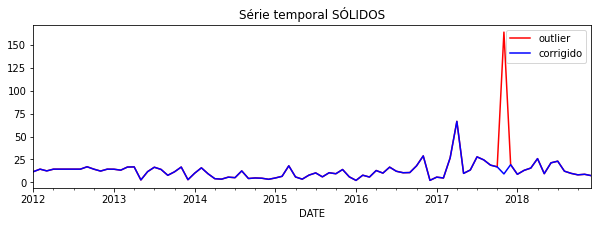

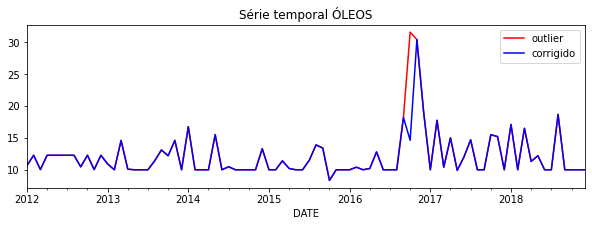

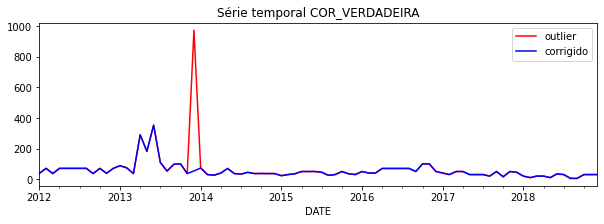

In [17]:
# comparar gráficos com e sem outlier
for col in df.columns:
    plt.figure(figsize=(10, 3))
    df[col].plot(color="red", label="outlier")
    df_imputed[col].plot(color="blue", label="corrigido")
    plt.legend()
    plt.title(f"Série temporal {col}")
    plt.show()

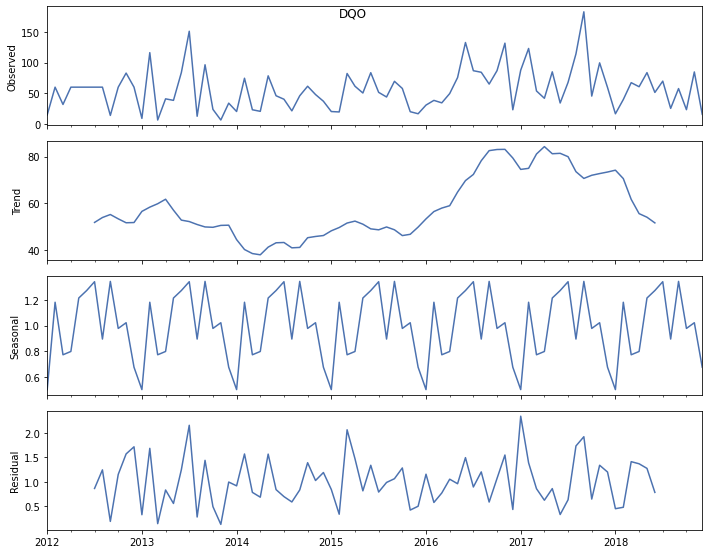

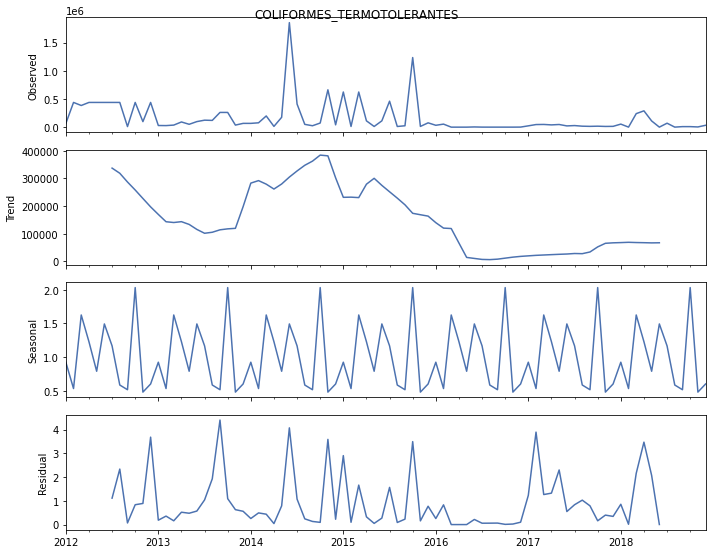

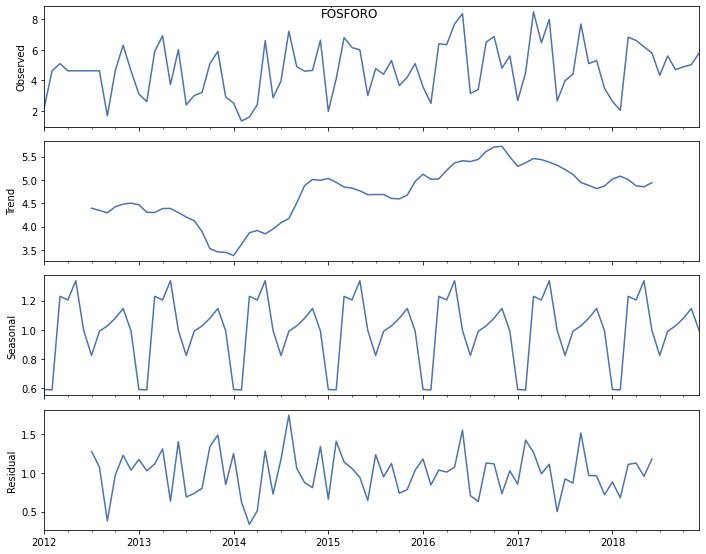

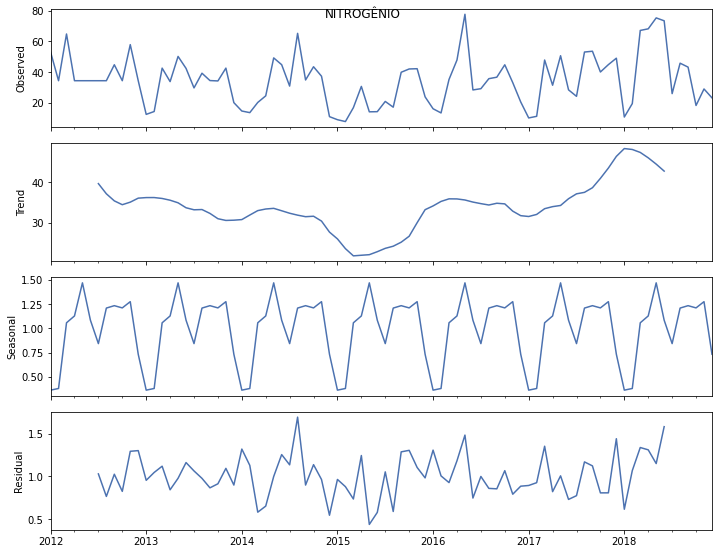

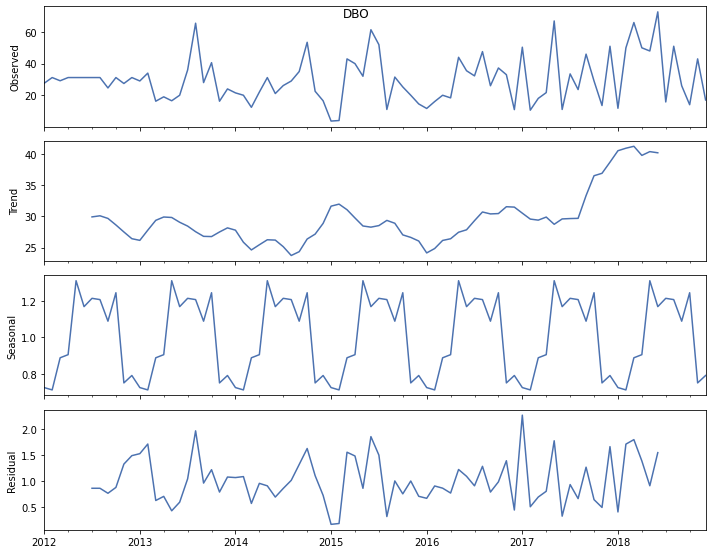

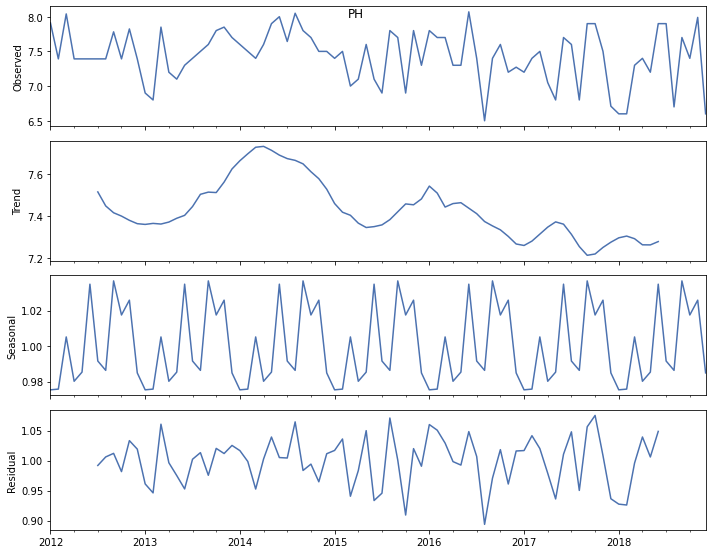

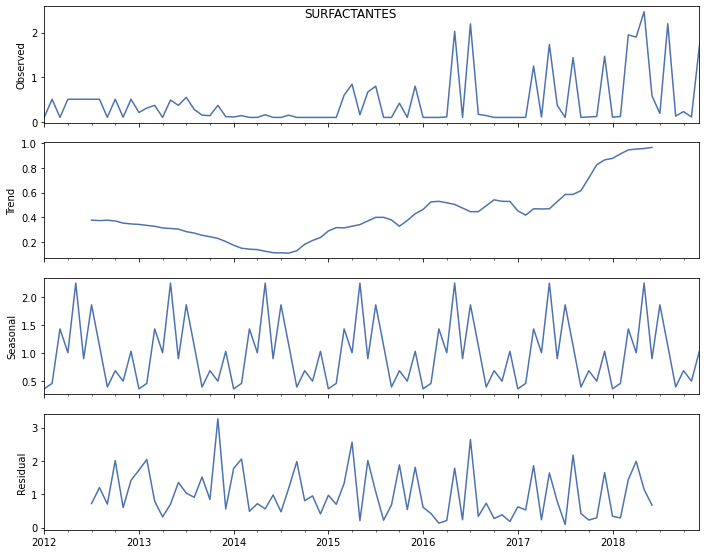

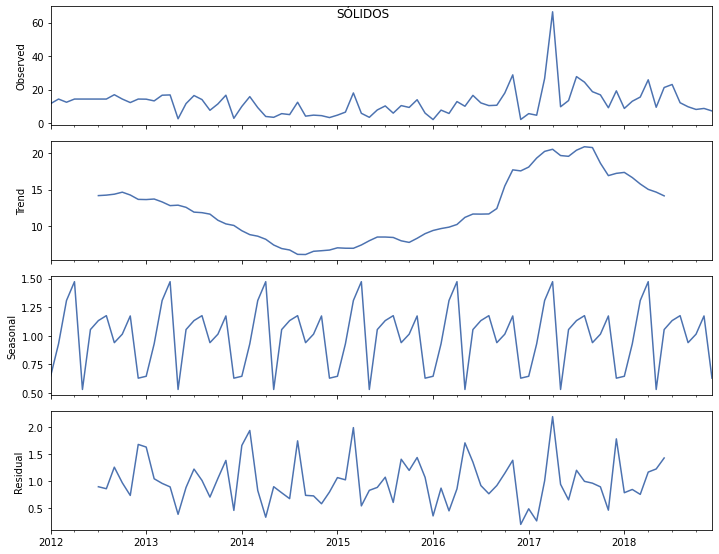

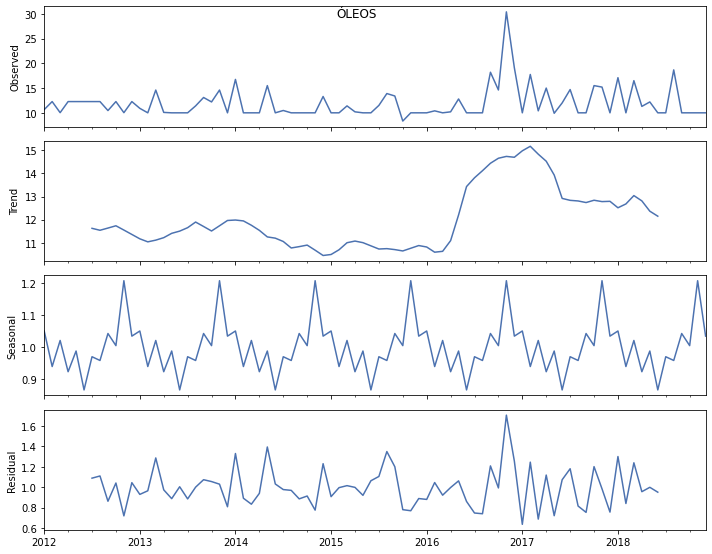

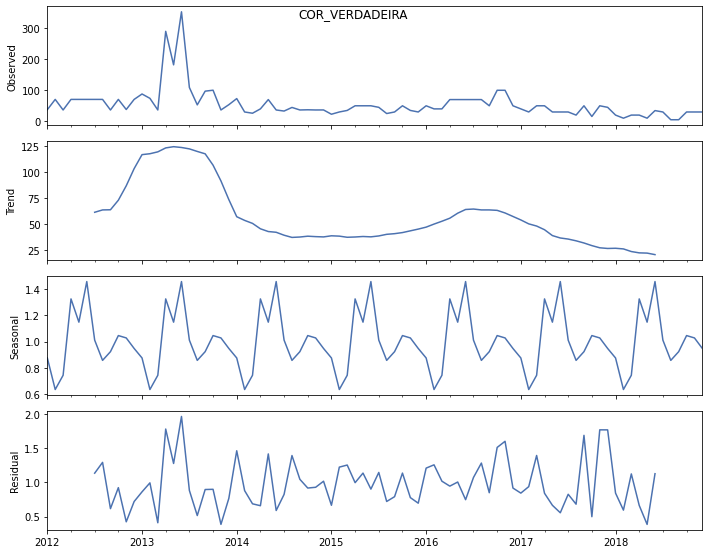

In [11]:
# Plotar decomposição das séries identificadas como estacionárias
for col in df_imputed.columns:
    decompose = seasonal_decompose(df_imputed[col], model='multiplicative')
    decompose.plot()
    plt.xlabel("")
    plt.suptitle(col);

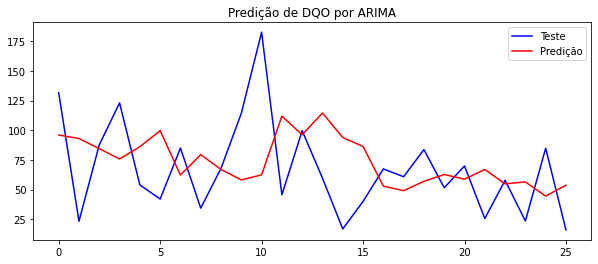

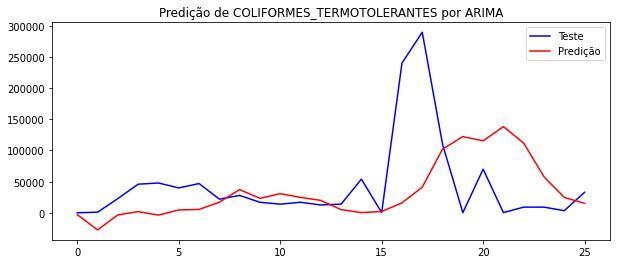

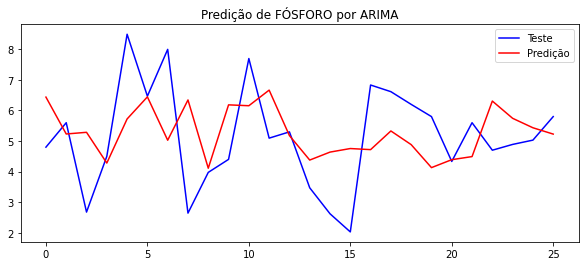

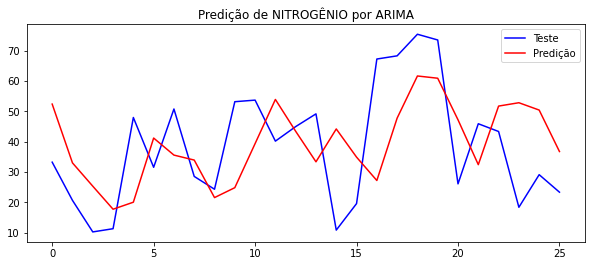

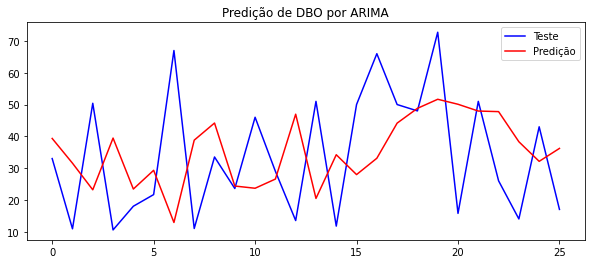

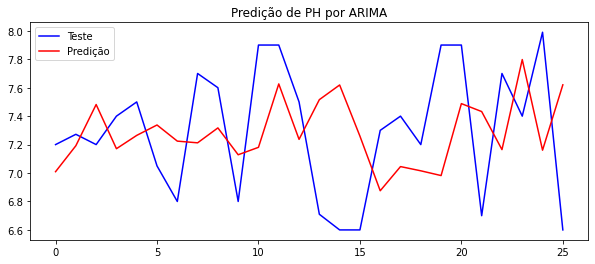

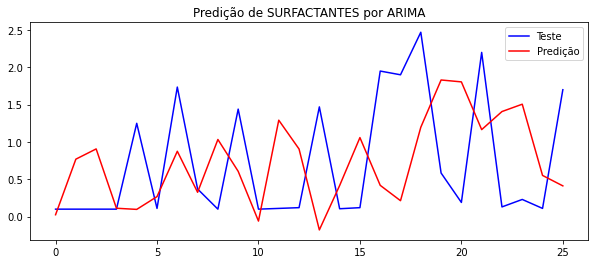

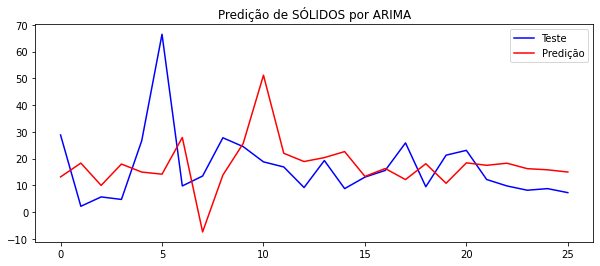

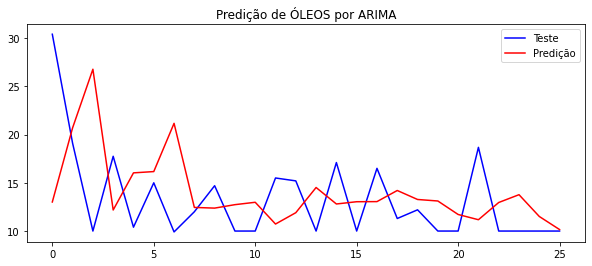

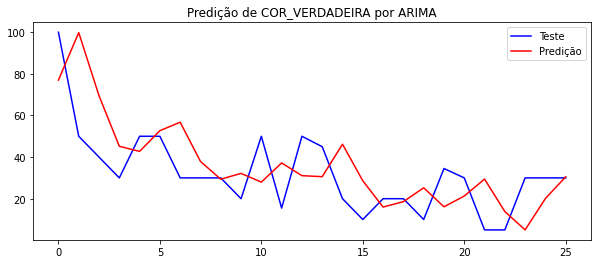

In [15]:
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

# definir modelo de predição, fitar valores e realizar predição
# idx = cols[0]
for idx in cols:
    series = df_imputed[idx].resample("M").mean().dropna()
    series.name = idx
    X = series.values
    size = int(len(X) * 0.70)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()

    for t in range(len(test)):
        model = ARIMA(history, order=(5, 1, 0)) 
        model_fit = model.fit(disp=0, maxiter=50)
        output = model_fit.forecast()
        yhat = output[0] 
        predictions.append(yhat)
        obs = test[t] 
        history.append(obs)
        # print(f"Predito: {float(yhat[0]):.1f}, Esperado: {obs:.1f}")

    error = mean_squared_error(test, predictions) 
    # print(f"\nMédia de Erro Quadrado do Teste (MSE): {error:.3f}\n")

    # plotar predição
    plt.figure(figsize=(10, 4))
    plt.plot(test, color="blue", label="Teste")
    plt.plot(predictions, color="red", label="Predição")
    plt.title(f"Predição de {idx} por ARIMA")
    plt.legend()
    plt.show()